In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Calculate limb darkening coefficients

First... some imports!

In [2]:
from ExoCTK import core
from ExoCTK.ldc import ldcfit as lf
from ExoCTK.ldc import ldcplot as lp
import matplotlib.pyplot as plt

To calculate the limb darkening coefficients, we need a model grid. 

I'm going to use the Phoenix ACES models for this example but any grid can be loaded into a `core.ModelGrid()` object if the spectra are stored as FITS files.

We will pass a directory or directory+wildcard path to the initialize the model grid.

We can also use the `resolution` argument to resample the model spectra. This greatly speeds up the caluclations.

In [3]:
fits_files = '/user/jfilippazzo/Models/ACES/default/'
model_grid = core.ModelGrid(fits_files, resolution=700)
print(model_grid.data)

518 models loaded from /user/jfilippazzo/Models/ACES/default/
 Teff  logg ...                          filename                         
------ ---- ... ----------------------------------------------------------
4400.0  3.0 ... lte04400-3.00-0.5.PHOENIX-ACES-AGSS-COND-SPECINT-2011.fits
4400.0  3.5 ... lte04400-3.50-0.5.PHOENIX-ACES-AGSS-COND-SPECINT-2011.fits
4400.0  4.0 ... lte04400-4.00-0.5.PHOENIX-ACES-AGSS-COND-SPECINT-2011.fits
4400.0  4.5 ... lte04400-4.50-0.5.PHOENIX-ACES-AGSS-COND-SPECINT-2011.fits
4400.0  5.0 ... lte04400-5.00-0.5.PHOENIX-ACES-AGSS-COND-SPECINT-2011.fits
4300.0  4.0 ... lte04300-4.00-0.5.PHOENIX-ACES-AGSS-COND-SPECINT-2011.fits
4300.0  4.5 ... lte04300-4.50-0.5.PHOENIX-ACES-AGSS-COND-SPECINT-2011.fits
4300.0  5.0 ... lte04300-5.00-0.5.PHOENIX-ACES-AGSS-COND-SPECINT-2011.fits
4300.0  5.5 ... lte04300-5.50-0.5.PHOENIX-ACES-AGSS-COND-SPECINT-2011.fits
4300.0  6.0 ... lte04300-6.00-0.5.PHOENIX-ACES-AGSS-COND-SPECINT-2011.fits
   ...  ... ...                       

Now let's customize it to our desired effective temperature, surface gravity, metallicity, and wavelength ranges by running the `customize()` method on our grid.

In [4]:
model_grid.customize(Teff_rng=(4500,4600), logg_rng=(5,5.5), FeH_rng=(-0.5,0.5), wave_rng=(1.1,1.9))

12/518 spectra in parameter range Teff: (4500, 4600) , logg: (5, 5.5) , FeH: (-0.5, 0.5) , wavelength: (1.1, 1.9)


Now we can caluclate the limb darkening coefficients using the `ldcfit.ldc()` function.

We just need to specify the desired effective temperature, surface gravity, metallicity, and the function(s) to fit to the limb darkening profile (including 'uniform', 'linear', 'quadratic', 'square-root', 'logarithmic', 'exponential', and 'nonlinear').

We can do this with for a single model on the grid...

quadratic :
wavelength   c1    e1    c2    e2 
---------- ----- ----- ----- -----
       1.1 0.224 0.012 0.248 0.017

4-parameter :
wavelength   c1    e1    c2     e2    c3    e3    c4     e4 
---------- ----- ----- ------ ----- ----- ----- ------ -----
       1.1 0.620 0.008 -0.016 0.019 0.039 0.019 -0.035 0.007



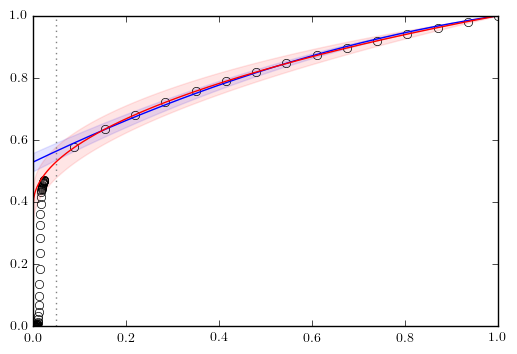

In [5]:
teff, logg, FeH = 4500, 5.0, 0.0
on_grid = lf.ldc(teff, logg, FeH, model_grid, ['quadratic','4-parameter'], plot=True)

...or a single model off the grid, where the spectral intensity model is directly interpolated before the limb darkening coefficients are calculated. This takes a minute...

In [7]:
teff, logg, FeH = 4512, 5.1, 0.1
off_grid = lf.ldc(teff, logg, FeH, model_grid, ['quadratic','4-parameter'], plot=True)

Loading flux into table...
Interpolating grid point [4512/5.1/0.1]...
Run time in seconds:  288.95376110076904


ValueError: There are 3 point arrays, but values has 0 dimensions

## Using a Photometric Bandpass

Above we caluclated the limb darkening in a particular wavelength range set when we ran the `customize()` method on our `core.ModelGrid()` object. 

Additionally, we can calculate the limb darkening through a particular photometric bandpass.

First we have to create a `core.Filter()` object which we can then pass to the functions in the `ldcfit` module. Let's use 2MASS H-band for this example.

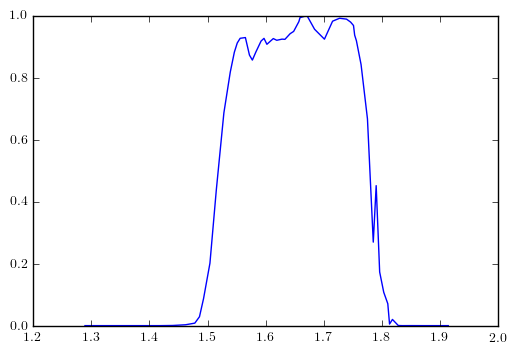

In [6]:
H_band = core.Filter('2MASS.H')
plt.plot(*H_band.rsr)

Now we can tell `ldcfit.ldc()` to apply the filter to the spectral intensity models before calculating the limb darkening coefficients using the `bandpass` argument. We'll compare the results of using the bandpass (blue line) to the plot above where we just used the wavelength window of 1.4-1.9 $\mu m$ (green line).

4-parameter :
wavelength   c1    e1    c2     e2    c3    e3    c4     e4 
---------- ----- ----- ------ ----- ----- ----- ------ -----
       1.1 0.620 0.008 -0.016 0.019 0.039 0.019 -0.035 0.007

4-parameter :
wavelength   c1    e1    c2     e2    c3    e3    c4     e4 
---------- ----- ----- ------ ----- ----- ----- ------ -----
   1.63795 0.868 0.012 -0.311 0.030 0.101 0.031 -0.029 0.012



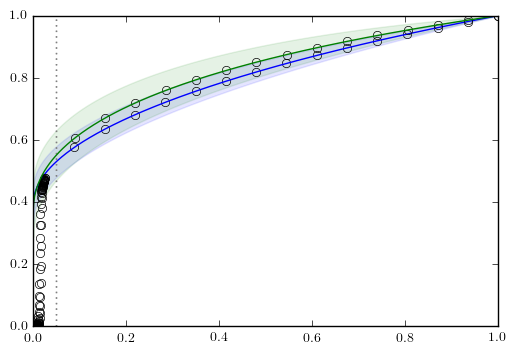

In [7]:
teff, logg, FeH = 4500, 5.0, 0.0
filt = lf.ldc(teff, logg, FeH, model_grid, ['4-parameter'], plot=True)
no_filt = lf.ldc(teff, logg, FeH, model_grid, ['4-parameter'], plot=plt.gcf(), bandpass=H_band, colors=['g'])

# Using a grism

Grisms are also supported and we can specify the number of bins or number of channels per bin.

In [ ]:
G141 = core.Filter('WFC3_IR.G141', n_bins=15)

Since we are going to use the G141 grism but previously were only interested in H-band, we must reset our model grid to include the G141 wavelength range.

In [ ]:
model_grid.reset()
model_grid.customize(Teff_rng=(4500,4600), logg_rng=(5,5.5), FeH_rng=(-0.5,0.5), wave_rng=(1.1,1.9))

Enjoy!